#### Jupyter Notebook to compute performance metrics from the segmentation predictions.


#### Imports

In [3]:
import numpy as np
from skimage import io
from scipy.misc import imread, imsave
import os
import imageio
import json
from skimage import transform
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from shutil import copy
from AxonDeepSeg.apply_model import axon_segmentation
from AxonDeepSeg.testing.segmentation_scoring import *
from scipy.misc import imread, imsave
%matplotlib inline

In [4]:
path_img = '/Users/rudinakaprata/Documents/Aldo/axondeepseg/AxonDeepSeg/data_test/image.png'

In [42]:
img = imageio.imread(path_img)
path_folder, file_name = os.path.split(path_img)

model_name = 'default_SEM_model_v1'
path_model = os.path.join('..','AxonDeepSeg','models',model_name)
path_configfile = os.path.join(path_model,'config_network.json')
with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())
    
mask = imageio.imread(os.path.join(path_folder,'mask.png'))
gt_axon = mask[:,:,1] > 200
gt_myelin = np.logical_and(mask[:,:,1] >= 50, mask[:,:,1] <= 200)

pred = imageio.imread(os.path.join(path_folder,'AxonDeepSeg.png'))
pred_axon = pred > 200
pred_myelin = np.logical_and(pred >= 50, pred <= 200)

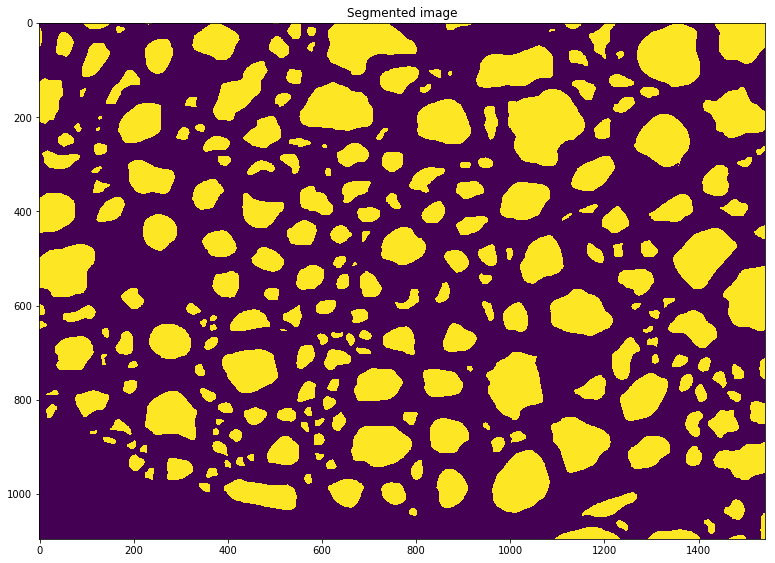

In [49]:
plt.figure(figsize=(13,10))
plt.title('Segmented image')
plt.imshow(gt_axon)
plt.show();

#### Function definitions

In [303]:
class Metrics_calculator: 
    
    def __init__(self, prediction_mask, groundtruth_mask):
        self.prediction_mask = prediction_mask
        self.groundtruth_mask = groundtruth_mask

    def pw_sensitivity(self):

        # Compute true positives count
        TP_count = np.logical_and(self.prediction_mask, self.groundtruth_mask).sum()

        # Compute positives count (TP+FN)
        P_count = self.groundtruth_mask.sum()
    
        # Compute sensitivity = TP/(TP+FN) = TP/P
        return np.true_divide(TP_count, P_count)
    
    def pw_precision(self):

        # Compute true positives count
        TP_count = np.logical_and(self.prediction_mask, self.groundtruth_mask).sum()

        # Compute false positives count
        FP_count = np.logical_and(self.prediction_mask == 1, self.groundtruth_mask == 0).sum()

        # Compute precision = TP/(TP+FP)
        return np.true_divide(TP_count, (TP_count + FP_count))       
    
    def pw_specificity(self):

        # Compute true negatives count
        TN_count = np.logical_and(self.prediction_mask == 0, self.groundtruth_mask == 0).sum()

        # Compute false positives count
        FP_count = np.logical_and(self.prediction_mask == 1, self.groundtruth_mask == 0).sum()

        # Compute specificity = TN/(TN+FP) = TN/N
        return np.true_divide(TN_count, (TN_count + FP_count))    
    
    def pw_FN_rate(self):

        # Compute false negative rate = 1 - sensitivity
        return (1 - self.pw_sensitivity())    
    
    def pw_FP_rate(self):

        # Compute false positive rate = 1 - specificity
        return (1 - self.pw_specificity())

    def pw_accuracy(self):

        # Compute true positives count
        TP_count = np.logical_and(self.prediction_mask, self.groundtruth_mask).sum()
    
        # Compute true negatives count
        TN_count = np.logical_and(self.prediction_mask == 0, self.groundtruth_mask == 0).sum()
    
        # Compute accuracy = (TP+TN)/total_count
        return np.true_divide((TN_count+TP_count), self.prediction_mask.size)

    def pw_F1_score(self):

        # Compute F1 score = 2*(precision*sensitivity)/(precision+sensitivity)
        return np.true_divide(2*(self.pw_sensitivity()*self.pw_precision()),(self.pw_sensitivity()+self.pw_precision()))

    def pw_dice(self):

        # Compute true positives count
        TP_count = np.logical_and(self.prediction_mask, self.groundtruth_mask).sum()
        
        # Compute false positives count
        FP_count = np.logical_and(self.prediction_mask == 1, self.groundtruth_mask == 0).sum()
    
        # Compute false negatives count
        FN_count = np.logical_and(self.prediction_mask == 0, self.groundtruth_mask == 1).sum()
    
        # Compute Dice = 2TP/(2TP+FP+FN)
        return np.true_divide(2*TP_count,2*TP_count+FP_count+FN_count)
    
    def pw_jaccard(self):

        # Compute true positives count
        TP_count = np.logical_and(self.prediction_mask, self.groundtruth_mask).sum()
        
        # Compute false positives count
        FP_count = np.logical_and(self.prediction_mask == 1, self.groundtruth_mask == 0).sum()
    
        # Compute false negatives count
        FN_count = np.logical_and(self.prediction_mask == 1, self.groundtruth_mask == 0).sum()
    
        # Compute Jaccard = TP/(TP+FP+FN)
        return np.true_divide(TP_count,TP_count+FP_count+FN_count)
    
    def ew_dice(self,output='short'):
        
        # Compute element-wise Dice for each object in masks
        ew_dice_raw = dice(self.prediction_mask, self.groundtruth_mask, self.prediction_mask, min_area=5)
        
        # Create dictionary with statistical metrics of the Dice distribution
        dice_list = {'mean': np.mean(ew_dice_raw.dice), 'std': np.std(ew_dice_raw.dice),
                     'min': np.min(ew_dice_raw.dice), 'max': np.max(ew_dice_raw.dice),
                     'percent_5': np.percentile(ew_dice_raw.dice,5), 'percent_10': np.percentile(ew_dice_raw.dice,10),
                     'percent_25': np.percentile(ew_dice_raw.dice,25), 'percent_50': np.percentile(ew_dice_raw.dice,50),
                     'percent_75': np.percentile(ew_dice_raw.dice,75), 'percent_90': np.percentile(ew_dice_raw.dice,90),
                     'percent_95': np.percentile(ew_dice_raw.dice,95)}
        
        if output=='all':
            return ew_dice_raw.dice
        if output=='short':
            return dice_list

    def hausdorff_distance(self):
        
        # Compute small erosion on both masks
        str_elem = disk(3)
        pred_eroded = binary_erosion(self.prediction_mask, str_elem)
        gt_eroded = binary_erosion(self.groundtruth_mask, str_elem)
        
        # Get outer contours
        pred_contour = np.logical_and(pred_eroded == 0 , self.prediction_mask == 1)
        gt_contour = np.logical_and(gt_eroded == 0 , self.groundtruth_mask == 1)
        
        # Compute element-wise Dice for each object in masks
        ew_dice_raw = dice(pred_contour, gt_contour, pred_contour, min_area=5)  

        # Create dictionary with statistical metrics of the Dice distribution
        dice_list = {'mean': np.mean(ew_dice_raw.dice), 'std': np.std(ew_dice_raw.dice),
                     'min': np.min(ew_dice_raw.dice), 'max': np.max(ew_dice_raw.dice),
                     'percent_5': np.percentile(ew_dice_raw.dice,5), 'percent_10': np.percentile(ew_dice_raw.dice,10),
                     'percent_25': np.percentile(ew_dice_raw.dice,25), 'percent_50': np.percentile(ew_dice_raw.dice,50),
                     'percent_75': np.percentile(ew_dice_raw.dice,75), 'percent_90': np.percentile(ew_dice_raw.dice,90),
                     'percent_95': np.percentile(ew_dice_raw.dice,95)}
        
        return dice_list, ew_dice_raw.dice

In [304]:
# Create object to manage segmentation metrics for axon mask
axon_metrics = Metrics_calculator(pred_axon, gt_axon)

# Compute and display results (pixelwise metrics):
print('Pixelwise Sensitivity:', axon_metrics.pw_sensitivity())
print('Pixelwise Accuracy:',axon_metrics.pw_accuracy())
print('Pixelwise Dice:',axon_metrics.pw_dice())
print('Pixelwise F1 score:',axon_metrics.pw_F1_score())
print('Pixelwise False negative rate:',axon_metrics.pw_FN_rate())
print('Pixelwise False positive rate:',axon_metrics.pw_FP_rate())
print('Pixelwise Jaccard index:',axon_metrics.pw_jaccard())
print('Pixelwise Precision:',axon_metrics.pw_precision())
print('Pixelwise Specificity:',axon_metrics.pw_specificity())

axon_metrics_array = np.array([axon_metrics.pw_sensitivity(),axon_metrics.pw_specificity(),axon_metrics.pw_precision(),
     axon_metrics.pw_accuracy(), axon_metrics.pw_F1_score(), axon_metrics.pw_dice(), axon_metrics.pw_jaccard()])

# Compute and display results (elementwise metrics):
#dice_output = axon_metrics.ew_dice('all')

print('Elementwise Dice:',axon_metrics.ew_dice('short'))
#print('Elementwise Hausdorff distance:',axon_metrics.hausdorff_distance())


('Pixelwise Sensitivity:', 0.9076187907633985)
('Pixelwise Accuracy:', 0.9537424745520257)
('Pixelwise Dice:', 0.9244337317700223)
('Pixelwise F1 score:', 0.9244337317700222)
('Pixelwise False negative rate:', 0.09238120923660154)
('Pixelwise False positive rate:', 0.025366003052247788)
('Pixelwise Jaccard index:', 0.8901509930222075)
('Pixelwise Precision:', 0.9418834752444024)
('Pixelwise Specificity:', 0.9746339969477522)
('Elementwise Dice:', {'percent_25': 0.8767890002044572, 'max': 0.9815956695693104, 'percent_90': 0.9606106310287573, 'percent_95': 0.9671646465092858, 'std': 0.08946780134447999, 'percent_5': 0.7528716212659238, 'min': 0.03177257525083612, 'percent_50': 0.9047224523612262, 'percent_75': 0.9411210683105606, 'percent_10': 0.8297145272467161, 'mean': 0.8924894743988269})


In [273]:
# Create object to manage segmentation metrics for myelin mask
myelin_metrics = Metrics_calculator(pred_myelin, gt_myelin)

# Compute and display results (pixelwise metrics):
print('Pixelwise Sensitivity:', myelin_metrics.pw_sensitivity())
print('Pixelwise Accuracy:',myelin_metrics.pw_accuracy())
print('Pixelwise Dice:',myelin_metrics.pw_dice())
print('Pixelwise F1 score:',myelin_metrics.pw_F1_score())
print('Pixelwise False negative rate:',myelin_metrics.pw_FN_rate())
print('Pixelwise False positive rate:',myelin_metrics.pw_FP_rate())
print('Pixelwise Jaccard index:',myelin_metrics.pw_jaccard())
print('Pixelwise Precision:',myelin_metrics.pw_precision())
print('Pixelwise Specificity:',myelin_metrics.pw_specificity())

myelin_metrics_array = np.array([myelin_metrics.pw_sensitivity(),myelin_metrics.pw_specificity(),myelin_metrics.pw_precision(),
                        myelin_metrics.pw_accuracy(), myelin_metrics.pw_F1_score(), myelin_metrics.pw_dice(), 
                        myelin_metrics.pw_jaccard()])

('Pixelwise Sensitivity:', 0.8394451437143301)
('Pixelwise Accuracy:', 0.8892687467139074)
('Pixelwise Dice:', 0.8388781484659574)
('Pixelwise F1 score:', 0.8388781484659577)
('Pixelwise False negative rate:', 0.1605548562856699)
('Pixelwise False positive rate:', 0.08467437234324582)
('Pixelwise Jaccard index:', 0.7216325381120721)
('Pixelwise Precision:', 0.8383119186436943)
('Pixelwise Specificity:', 0.9153256276567542)


#### Visualization of pixelwise metrics for both axon and myelin

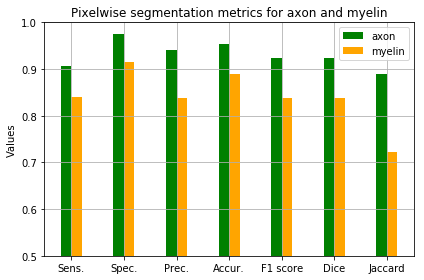

In [286]:
n_groups = 7
fig, ax = plt.subplots()
index = np.arange(n_groups)

rects1 = plt.bar(index-0.1, axon_metrics_array, width=0.2, color='green',label='axon')
rects2 = plt.bar(index+0.1, myelin_metrics_array, width=0.2, color='orange',label='myelin')

plt.ylabel('Values')
plt.title('Pixelwise segmentation metrics for axon and myelin')
plt.xticks(index, ('Sens.', 'Spec.', 'Prec.', 'Accur.', 'F1 score','Dice','Jaccard'),fontsize=10)
plt.legend(loc='best')
plt.grid(True)
plt.ylim(0.5, 1)

plt.tight_layout()
plt.show()

[]

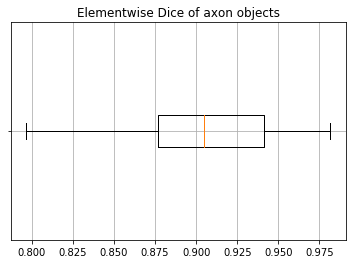

In [305]:
plt.figure()
plt.boxplot(dice_output, 0, '',vert=False)
plt.title('Elementwise Dice of axon objects')
plt.grid(True)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])


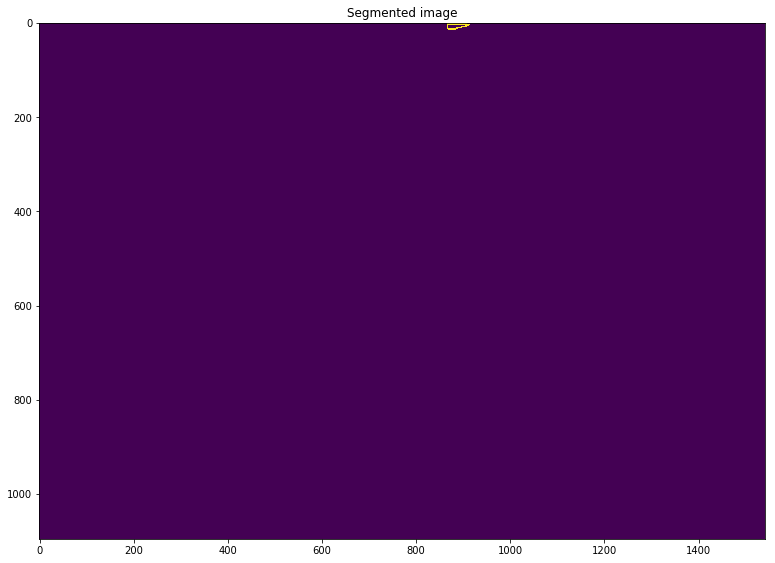

In [199]:
from skimage.morphology import binary_erosion, disk, label

str_elem = disk(3)
eroded = binary_erosion(pred_axon,str_elem)
final = np.logical_and(eroded == 0 , pred_axon == 1)
a = label(final)
b = a==6

plt.figure(figsize=(13,10))
plt.title('Segmented image')
plt.imshow(b)
plt.show();

In [143]:
from scipy.spatial.distance import directed_hausdorff

a=directed_hausdorff(pred_axon, gt_axon)[0]
print(a)

13.8202749611


In [ ]:
def dice(img, groundtruth, prediction, min_area=3):
    """
    :param img: image to segment
    :param groundtruth : True segmentation
    :param prediction : Segmentation predicted by the algorithm
    :param min_area: minimum area of the predicted object to measure dice
    :return dice_scores: pandas dataframe associating the axon predicted, its size and its dice score

    To get the global dice score of the prediction,
    """

    h, w = img.shape

    labels_true = measure.label(groundtruth)
    regions_true = regionprops(labels_true)

    labels_pred = measure.label(prediction)
    regions_pred = regionprops(labels_pred)
    features = ['coords', 'area', 'dice']
    df = pd.DataFrame(columns=features)

    i = 0
    for axon_predicted in regions_pred:
        centroid = (np.array(axon_predicted.centroid)).astype(int)
        if groundtruth[(centroid[0], centroid[1])] == 1:
            for axon_true in regions_true:

                if [centroid[0], centroid[1]] in axon_true.coords.tolist():
                    surface_pred = np.zeros((h, w))
                    surface_true = np.zeros((h, w))

                    surface_pred[axon_predicted.coords[:, 0], axon_predicted.coords[:, 1]] = 1
                    surface_true[axon_true.coords[:, 0], axon_true.coords[:, 1]] = 1
                    intersect = surface_pred * surface_true

                    Dice = 2 * float(sum(sum(intersect))) / (sum(sum(surface_pred)) + sum(sum(surface_true)))
                    df.loc[i] = [axon_predicted.coords, axon_predicted.area, Dice]
                    break
        i += 1
    dice_scores = df[df['area'] > min_area]
    return dice_scores

In [164]:
a = dice(pred, gt_axon, pred_axon, min_area=3)

In [184]:
print(np.mean(a.dice))
print(np.max(a.dice))
print(np.std(a.dice))
print(np.percentile(a.dice,50))

dict_metrics = {'dice mean': np.mean(a.dice), 'dice_myelin': np.mean(a.dice)}
print(dict_metrics)

0.8924894743988269
0.9815956695693104
0.08946780134447999
0.9047224523612262
{'dice mean': 0.8924894743988269, 'dice_myelin': 0.8924894743988269}
